# Unit 06

`````{tab-set}
````{tab-item} Objective

::::{important} Objective

In this hands-on session, the objective is to perform **supervised classification** of dyes into the categories *cyanines* and *acridines* based on both structural and/or electronic features.

- To achieve this, first create two scalar (single-value) invariant features from the given dataset.
- Apply different methods of your choice (*e.g.*, **k-Nearest Neighbors, Logistic Regression, and Random Forest Classifier**) to group the dyes based on this electronic descriptor.
- What is the maximum accuracy you can achieve? What are the features and which with method? (Send this final result to Prof. Müller vis Mail)

In this example, we will analyze a dataset containing class labels for 40 dyes, with one molecule missing a class label. Our goal is to train classification models that not only accurately describe the training and test data but also predict the class label for the one sample where it is missing.

The reference data for training is obtained from [PhotochemCAD](https://www.photochemcad.com/).

::::

````


````{tab-item} Further Information

:::{admonition}Further Information


**pandas** and **pandas.DataFrame**
- [`pandas.DataFrames` (1)](https://pandas.pydata.org/docs/user_guide/10min.html)
- [`pandas.DataFrames` (2)](https://www.w3schools.com/python/pandas/pandas_dataframes.asp)
- [`pandas.DataFrames` (3)](https://www.datacamp.com/tutorial/pandas-tutorial-dataframe-python)

**sklearn**
- [k-Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

- [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- [Decision Boundaries](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)
- [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Pipelining and grid search](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html#pipelining)

:::

````
`````


In [1]:
# general packages which are might required
import pickle, sys, os
import numpy as np
import pandas as pd

# packages for plotting
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import digichem as dc
from digichem import FP, Spectrum

In [3]:
# load data from pickle file
with open('df_acridines_cyanines_unknownpkl.pkl', 'rb') as handle:
    df = pickle.load(handle)

df.head(n=5)

/tmp/ipykernel_6216/3902306003.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(handle)


,dye_category,smiles,abs_max,abs_spec
K01,cyanines,CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21,524.25,"220.0 to 900.0 nm, steps: 1.0 nm"
K02,cyanines,CCN1/C(=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21,603.50,"220.0 to 900.0 nm, steps: 1.0 nm"
K03,cyanines,CCN1/C(=C/C=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccc...,711.00,"220.0 to 900.0 nm, steps: 1.0 nm"
K04,cyanines,CCN1C=C/C(=C\c2cc[n+](CC)c3ccccc23)c2ccccc21,592.00,"220.0 to 900.0 nm, steps: 1.0 nm"
K05,cyanines,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc21,709.50,"220.0 to 900.0 nm, steps: 1.0 nm"


## A) Inspection and pre-processing of data

::::{tip} Task 6.1 - Feature Generation and Selection

While machine learning models can easily handle multidimensional features (such as vectors, arrays, or tensors), in this exercise we will focus on only two scalar (single-value) invariant features. This restriction will allow us to visualize decision boundaries effectively.

As in any machine learning task, feature selection is flexible and can be done in many ways. You are free to choose any two features you can derive — for example:

- From the **absorption spectrum** (*e.g.*, the position of a local maximum or the integral over a specific wavelength range), or
- From the molecular **structure** (available as SMILES strings in the dataset).

::::

/tmp/ipykernel_6216/4038346823.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(absorb, wl)


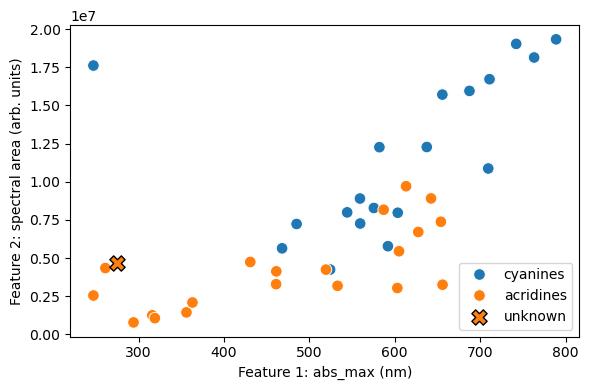

In [4]:
# creating features

import numpy as np
from digichem import Spectrum  # already imported above

# 1) Use abs_max directly as first feature
df["feat_abs_max"] = df["abs_max"]

# 2) Define a helper to compute the spectral area from the Spectrum object
def compute_spectral_area(spec: Spectrum) -> float:
    """
    Compute area under the absorption curve using the trapezoidal rule.
    spec.spec is an (N, 2) array: [:, 0] = wavelength, [:, 1] = absorbance
    """
    wl = spec.spec[:, 0]
    absorb = spec.spec[:, 1]
    area = np.trapz(absorb, wl)
    return area

# 3) Apply to all rows to get our second scalar feature
df["feat_area_abs"] = df["abs_spec"].apply(compute_spectral_area)

# Quick check
df[["dye_category", "feat_abs_max", "feat_area_abs"]].head()


import seaborn as sns
import matplotlib.pyplot as plt

# separate known and unknown
df_known = df[df["dye_category"] != "unknown"]
df_unknown = df[df["dye_category"] == "unknown"]

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_known,
    x="feat_abs_max",
    y="feat_area_abs",
    hue="dye_category",
    s=70
)

# mark the unknown sample on top
plt.scatter(
    df_unknown["feat_abs_max"],
    df_unknown["feat_area_abs"],
    marker="X",
    s=120,
    edgecolor="k",
    label="unknown"
)

plt.xlabel("Feature 1: abs_max (nm)")
plt.ylabel("Feature 2: spectral area (arb. units)")
plt.legend()
plt.tight_layout()
plt.show()




::::{tip} Task 6.2 - Data Splitting

Prior to the supervised machine learning for classification, we have to split our data into a set of training and test data and furthermore prepare the unlabelled data point:

Please create a ```pd.DataFrame``` of the labeled data, including two columns for the features derived from the absorption spectra of the dyes.
Additionally, create a ```pd.Series``` for the respective labels (`acridines` or `cyanines`).

Ensure that the unlabeled data point is separated from the original dataset and is not included in either the training or test sets. 
Prepare this unlabeled data point in a similar pd.DataFrame format, as it will be used to predict the label using our trained model.

:::{admonition} Data Splitting (sklearn)
:class: dropdown

Before performing supervised machine learning for classification, it is crucial to properly split your data into training and test sets to evaluate the model's performance accurately. This ensures that the model generalizes well to new, unseen data. Improper data splitting can lead to misleading performance metrics and overfitting.

Typically, 70-80% of the data is used for training, and the remaining 20-30% is used for testing. This balance allows the model to learn effectively while having enough data to validate its performance.

To split your data in Python using scikit-learn, you can use the train_test_split function. Here is an example:

```{code-block} python
:lineno-start: 1
:emphasize-lines: 4

from sklearn.model_selection import train_test_split

# Assuming 'X' is your DataFrame of features and 'y' is your Series of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size=0.2' means 20% of the data will be used for testing
```

:::

::::

In [5]:
from sklearn.model_selection import train_test_split


# === Task 6.2: Data Splitting ===

from sklearn.model_selection import train_test_split

# 1. Separate labeled and unlabeled data
df_labeled = df[df["dye_category"] != "unknown"].copy()
df_unlabeled = df[df["dye_category"] == "unknown"].copy()

# 2. Prepare X and y for the labeled dataset
feature_cols = ["feat_abs_max", "feat_area_abs"]

X = df_labeled[feature_cols]
y = df_labeled["dye_category"]

# 3. Perform the train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test data
    random_state=42,     # fixed for reproducibility
    stratify=y           # optional but better → keeps class ratio
)

# 4. Prepare the unlabeled sample (for prediction later)
X_unknown = df_unlabeled[feature_cols]

# Quick check of shapes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Unknown sample shape:", X_unknown.shape)

df_labeled.head(), df_unlabeled



Training set size: (32, 2)
Test set size: (8, 2)
Unknown sample shape: (1, 2)


(    dye_category                                             smiles  abs_max  \
 K01     cyanines         CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21   524.25   
 K02     cyanines     CCN1/C(=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21   603.50   
 K03     cyanines  CCN1/C(=C/C=C/C=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccc...   711.00   
 K04     cyanines       CCN1C=C/C(=C\c2cc[n+](CC)c3ccccc23)c2ccccc21   592.00   
 K05     cyanines   CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc21   709.50   
 
                              abs_spec  feat_abs_max  feat_area_abs  
 K01  220.0 to 900.0 nm, steps: 1.0 nm        524.25   4.246767e+06  
 K02  220.0 to 900.0 nm, steps: 1.0 nm        603.50   7.968794e+06  
 K03  220.0 to 900.0 nm, steps: 1.0 nm        711.00   1.672077e+07  
 K04  220.0 to 900.0 nm, steps: 1.0 nm        592.00   5.776645e+06  
 K05  220.0 to 900.0 nm, steps: 1.0 nm        709.50   1.086969e+07  ,
     dye_category                               smiles  abs_max  \
 I22      unknown  N=1C=

## B) Supervised Classification



:::::{tip} Task 6.3 - Supervised Classification

The objective in this section is to train different classifiers to distinguish acridines and cyanines based on the two features extracted from the absorption data of the respective dyes.

::::{admonition} Example: kNN model
:class: dropdown

The standard workflow in working with sklearn models, can be described as follows using the example of kNN:

STEP 1 - Import Libraries 
: We start by importing necessary classes from scikit-learn. These include KNeighborsClassifier for the kNN algorithm, Pipeline to streamline the preprocessing and modeling steps, and StandardScaler to standardize the features.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 2,3

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
```

STEP 2 - Define the Scaler
: We create an instance of StandardScaler which standardizes features by removing the mean and scaling to unit variance. This is an essential preprocessing step to ensure the kNN algorithm performs well, as it relies on distance calculations.

```{code-block} python
:lineno-start: 4
:emphasize-lines: 5

# define scaling (mean=0, variance=1)
scaler = StandardScaler()
```

STEP 3 - Define the kNN Model
: We instantiate the KNeighborsClassifier with n_neighbors=2, which means the algorithm will consider the 2 nearest neighbors to make a classification decision.

```{code-block} python
:lineno-start: 6
:emphasize-lines: 7

# kNN considering 2 nearest neighhbors for classification
knn = KNeighborsClassifier(n_neighbors=2)
```

STEP 4 - Create a Pipeline
: We combine the scaler and kNN model into a pipeline. This ensures that the data is first scaled before being passed to the kNN classifier. The pipeline helps in maintaining a clean and efficient workflow.

```{code-block} python
:lineno-start: 8
:emphasize-lines: 9

# pipeline combining scaling and kNN model 
knn_clf = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
```

STEP 5 - Fit the Model
: We fit the pipeline to the training data (X_train and y_train). In this context, fitting means the scaler will compute the mean and variance from the training data, which will be used to transform the data. The kNN model will then use this transformed data for making predictions.

```{code-block} python
:lineno-start: 10
:emphasize-lines: 11

# train model (remember: kNN has no training but is instance-based/lazy learner)
knn_clf.fit(X_train, y_train)
```

:::{admonition} Complete Code
:class: dropdown

```{code-block} python
:lineno-start: 1
:emphasize-lines: 12

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define scaling (mean=0, variance=1)
scaler = StandardScaler()

# kNN considering 2 nearest neighhbors for classification
knn = KNeighborsClassifier(n_neighbors=2)

# pipeline combining scaling and kNN model 
knn_clf = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

# train model (remember: kNN has no training but is instance-based/lazy learner)
knn_clf.fit(X_train, y_train)
```
:::

:::{admonition} Finding the Optimal k-Value for kNN Classification
:class: dropdown

Upon fitting the kNN model with a specific k-value, you can access the score, which indicates how accurately the model classifies the labeled data. For example, a score of 1.0 on the test set means the model correctly classified every test data point.

In python you can access the scores and predictions with the score and predcit functions:

```{code-block} python
:lineno-start: 12

# score (function takes features and labels and returns score)
knn_clf.score(X_test, y_test)

# prediction (function takes only features and returns a label)
knn_clf.score(X_sample)
```

To find the optimal k-value, perform kNN classification for various k-values and evaluate their scores. By comparing these scores, you can determine the best k-value for your model.
Instructions:

1. Perform kNN classification for a range of k-values.
2. Calculate the scores for both the training and test data for each k-value.
3. Visualize how the scores on the test and training data depend on the k-value.
3. Based on the visualization, choose the optimal k-value.

:::

::::

::::{admonition} Assessing the Model's Quality
:class: dropdown

Now that we have chosen the optimal k-value, we will train a kNN model using this value and analyze its performance. To do this, we will examine two different measures: the confusion matrix and decision boundaries.

1. Train the kNN model using the optimal k-value.
2. Generate and analyze the confusion matrix for the test data.
3. Visualize the decision boundaries of the trained model. Visualize the data point with unknown label. Is the model able to describe the class of this dye correct?

:::{admonition} Confusion Matrix
:class: dropdown

The confusion matrix is a table that summarizes the performance of a classification algorithm. It shows the number of correct and incorrect predictions made by the model compared to the actual classifications. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class. This matrix helps to assess the model's quality by providing insights into its accuracy, precision, recall, and ability to distinguish between different classes.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 6

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_test, knn_clf.predict(X_test))

# convert array into pd.DataFrame
cm_matrix = pd.DataFrame(
    data=cm, 
    columns=['Actual: Acridine', 'Actual: Cyanine'], 
    index=['Predict: Acridine', 'Predict: Cyanine']
)

# visualize the confusion matrix as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='rocket_r')
```
:::

:::{admonition} Decision Boundaries
:class: dropdown

Decision boundaries are the surfaces that separate different classes predicted by the model. In the context of kNN, these boundaries illustrate how the algorithm divides the feature space based on the training data. Visualizing decision boundaries helps to assess the model's quality by showing how well the model generalizes to new data and how it handles different regions of the feature space. It can reveal whether the model is overfitting or underfitting the data.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 4,5,6,7,8,9,10

from sklearn.inspection import DecisionBoundaryDisplay

# compute and visualize descion boundaries from the classifier
disp = DecisionBoundaryDisplay.from_estimator(
    knn_clf, 
    X_all.values, 
    response_method="predict",
    xlabel='feature 1', 
    ylabel='feature 2',
)

# indicate class by color in scatterplot
color_mapping = {'cyanines': 'blue', 'acridines': 'orange'}
colors = [color_mapping[label] for label in y_all]

disp.ax_.scatter(X_all['feature 1'].values, X_all['feature 2'].values, c=colors)
```
:::
::::

:::::

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# train a model of your choice

import numpy as np

# range of k values to test
k_values = range(1, 17)
train_scores = []
test_scores = []

for k in k_values:
    knn_clf = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k)),
    ])
    knn_clf.fit(X_train, y_train)

    train_scores.append(knn_clf.score(X_train, y_train))
    test_scores.append(knn_clf.score(X_test, y_test))

    print(f"k = {k:2d} | train acc = {train_scores[-1]:.2f} | test acc = {test_scores[-1]:.2f}")

# choose k with best test accuracy
best_k = k_values[int(np.argmax(test_scores))]
print("\nBest k based on test accuracy:", best_k)

# train final model with best k
knn_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k)),
])
knn_clf.fit(X_train, y_train)

print("Final train accuracy:", knn_clf.score(X_train, y_train))
print("Final test accuracy :", knn_clf.score(X_test, y_test))

# predict class of the unknown dye
y_unknown_pred = knn_clf.predict(X_unknown)
print("Predicted class for unknown dye:", y_unknown_pred[0])


k =  1 | train acc = 1.00 | test acc = 0.62
k =  2 | train acc = 0.91 | test acc = 0.75
k =  3 | train acc = 0.94 | test acc = 0.75
k =  4 | train acc = 0.88 | test acc = 0.75
k =  5 | train acc = 0.91 | test acc = 0.75
k =  6 | train acc = 0.84 | test acc = 0.75
k =  7 | train acc = 0.88 | test acc = 0.75
k =  8 | train acc = 0.84 | test acc = 0.75
k =  9 | train acc = 0.91 | test acc = 0.75
k = 10 | train acc = 0.84 | test acc = 0.75
k = 11 | train acc = 0.84 | test acc = 0.88
k = 12 | train acc = 0.75 | test acc = 0.75
k = 13 | train acc = 0.78 | test acc = 0.88
k = 14 | train acc = 0.78 | test acc = 0.75
k = 15 | train acc = 0.78 | test acc = 0.75
k = 16 | train acc = 0.81 | test acc = 0.62

Best k based on test accuracy: 11
Final train accuracy: 0.84375
Final test accuracy : 0.875
Predicted class for unknown dye: acridines


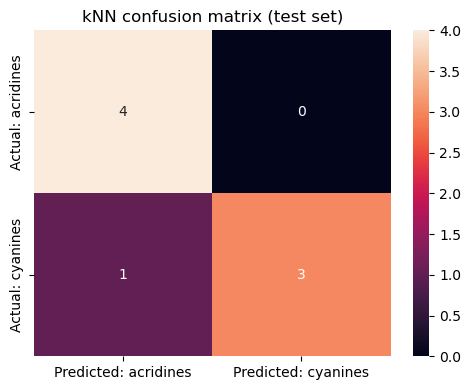

In [12]:
from sklearn.metrics import confusion_matrix

# plot confusion matrix for test / training data
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# confusion matrix on test set
cm = confusion_matrix(y_test, knn_clf.predict(X_test),
                      labels=["acridines", "cyanines"])

cm_matrix = pd.DataFrame(
    cm,
    index=["Actual: acridines", "Actual: cyanines"],
    columns=["Predicted: acridines", "Predicted: cyanines"]
)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_matrix, annot=True, fmt='d')
plt.title("kNN confusion matrix (test set)")
plt.tight_layout()
plt.show()


/home/hatef/miniconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


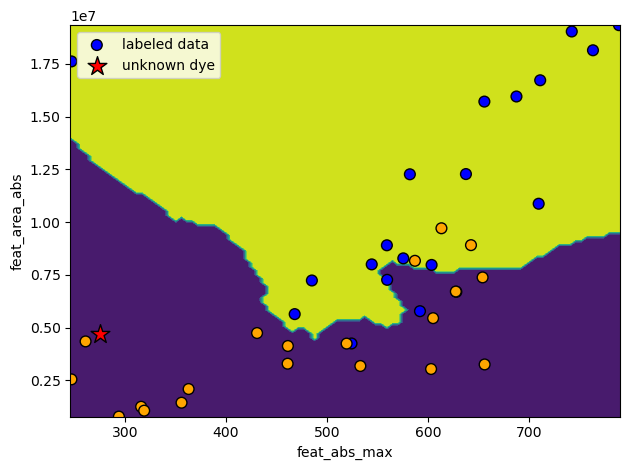

In [13]:
from sklearn.inspection import DecisionBoundaryDisplay

# plot decision boundaries
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# all labeled data (for nicer plot)
X_all = df_labeled[feature_cols]
y_all = df_labeled["dye_category"]

disp = DecisionBoundaryDisplay.from_estimator(
    knn_clf,
    X_all.values,
    response_method="predict",
    xlabel="feat_abs_max",
    ylabel="feat_area_abs",
)

# color points by class
color_mapping = {'cyanines': 'blue', 'acridines': 'orange'}
colors = [color_mapping[label] for label in y_all]

disp.ax_.scatter(
    X_all["feat_abs_max"],
    X_all["feat_area_abs"],
    c=colors,
    edgecolor="k",
    s=60,
    label="labeled data",
)

# add the unknown dye
disp.ax_.scatter(
    X_unknown["feat_abs_max"],
    X_unknown["feat_area_abs"],
    marker="*",
    s=200,
    c="red",
    edgecolor="k",
    label="unknown dye",
)

disp.ax_.legend()
plt.tight_layout()
plt.show()


:::::{tip} Task 6.4 - Choose a model for the task/dataset 

Now that you have configured classifiers with optimized hyperparameters, let's use these models to predict the class of the unlabelled data point. Examine the details of the unlabelled molecule and determine if the models accurately classify its class.

What is your classification result? Are your models suited for performing classification based on the chosen two features considering that the unknown compound should be classified as acridine?

:::::

In [14]:
# model predictions for unlabelled data - acridines is correct
# predict the label for the unlabeled sample (Task 6.4)

y_unknown_pred = knn_clf.predict(X_unknown)[0]
print("Predicted class for the unknown dye:", y_unknown_pred)

# check if model prediction matches expected class ("acridines")
if y_unknown_pred == "acridines":
    print("→ Correct: the model classifies the unknown compound as an acridine.")
else:
    print("→ Incorrect: the model misclassified the unknown compound.")


Predicted class for the unknown dye: acridines
→ Correct: the model classifies the unknown compound as an acridine.
